*Authors: Ema Donev and dr. Ivezić*

This notebook contains all the information necessary to understand the data, its descriptive statistics, and how to plot light curves of both `LINEAR` and `ZTF` data.

### Importing necessary libraries and configuration

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# Multithreading/multiprocessing libraries
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading

In [2]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from ZTF_data import *
from config import*
from descriptive_stats import *
from plots import *

Loading the data!


# Downloading `LINEAR` and `ZTF` data

## `LINEAR` dataset

The `LINEAR dataset` *(Lincon Near-Earth Asteroid Research)* contains 7010 light curves of periodic variable stars. While the original mission of this survey was to find asteroids, it subsequently monitored a substantial portion of the sky, cataloging the brightness of various variable stars. This survey was operated with two telescopes on a site in New Mexico. The two telescopes are equatorially mounted of GEODSS type, where each telescope is denoted as L1 and L2. They observed a broad part of the visible spectrum and the near-infrared spectrum. 

The preprocessing process contained the following procedures:
1. **Bias correction**: removing noise created by the camera
2. **Flat-field correction**: removing artificial lines and gradients due to varying sensitivities of pixels
3. **Preliminary fixed-aperture photometry**: subtracting the background light using Poisson statistics

After preprocessing, the data had to be astrometrically recalibrated, meaning that the scientists had to ensure the coordinates of the objects in the data matched another survey, like SDSS. Of all the data, 7% had bad astrometry (the coordinates did not fit), so the scientists removed them from the dataset. The rest of the data had a 1-2% error in astrometry.

Next up was photometric recalibration, meaning that the filters and fluxes had to be recalibrated to match SDSS data. The corrections regarded CCD camera errors, correcting the magnitudes of objects in the data, and correcting underestimated magnitude errors. After the photometric recalibration, the data were grouped into various categories, including a variable star category. While the original dataset has 5 billion objects, *only 7010 are confirmed periodic variable stars*. The scientists subsequently analyzed this portion of the dataset by categorizing the light curves, calculating their periods, and inferring conclusions from the preceding factors. 

We can access the `LINEAR` dataset via one line of code since we are downloading the data from the AstroML library.

In [4]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

In [5]:
# acessing all of the light curves from the dataL and checking if any light curve is missing
c = 0 
for i in dataL.ids: # iterating through all of the dataL ID's
    light_curve = dataL.get_light_curve(i) # fetching the light curve dataL for a specific ID
    c += 1 
print(f'The number of light curves in the LINEAR dataset:{c}') 

The number of light curves in the LINEAR dataset:7010


The counter has printed the number `7010`, the correct amount of light curves in this dataset. No light curves are missing!

#### Structure of `LINEAR` dataset

The structure of the `LINEAR` dataset is as such:
1. `dataL` is a `AstroML.datasets` object and it contains the following:

1.a) `dataL.ids` is a list of all the IDs of the stars

1.b) `dataL.get_light_curve()` is a function which acceses the data for a specific ID of a light curve every light curve is a `np.array()` object where every column is `time`, `magnitude` and the  `magnitude error`. In order to get an array for every column the original array must be transposed.

2. `dataL.targets` contains all of the metadata for every light curve eg. rectascension, declination, etc.


Here is an example of a light curve:

LINEAR ID:10003298
(10003298, 207.52946, 33.70615, 207.529404, 33.706001, 15.73, 1.84, 0.81, 0.31, 0.16, 0.63, 15.89, 0.16, 0.19, 1.12, -0.61, -0.01, -1, 0)
Rectascension:207.529404, and Declination:33.706001


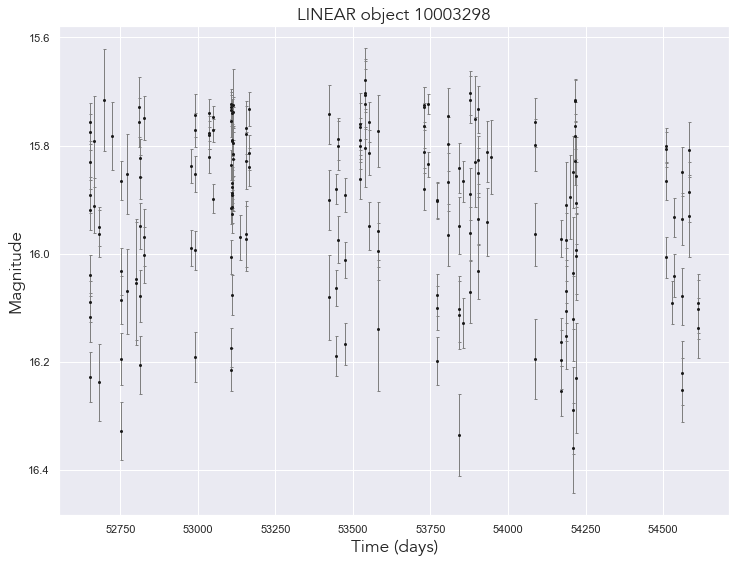

In [6]:
ID = dataL.ids[0] # accessing the first LINEAR ID
lc = dataL.get_light_curve(ID)
time, mag, magerr = lc.T # transposing the data
#--------
print(f'LINEAR ID:{ID}')
targets = dataL.targets[0]
print(targets)
ra, dec = targets[3], targets[4]
print(f'Rectascension:{ra}, and Declination:{dec}')
#--------
fig, ax = plt.subplots(1,1, figsize=(12,9)) # creating subplots with 2 columms and 3 rows
ax.errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5)
ax.set_xlabel('Time (days)',fontproperties=font)
ax.set_ylabel('Magnitude', fontproperties=font)
ax.set_title('LINEAR object {0}'.format(ID), fontproperties=font)
ax.invert_yaxis()
plt.show()

For further analysis we will require the `LINEAR ID`, the `ra` and `dec` values, and finally, the data for every light curve (time, magnitude, errors).

### Introductory statistics of `LINEAR` data

In [10]:
# NUMBER OF MEASUREMENTS
# -----------------------
pL = []
for i in dataL.ids:
    lc = dataL.get_light_curve(i)
    t, m, me = lc.T
    pL.append(len(t))

total_obser = sum(pL) # summing the number of measurements of every light curve
avg = total_obser/c
print(f'Our dataset contains {total_obser} observations, with an average of {round(avg, 4)} observations.')

Our dataset contains 1851936 observations, with an average of 264.1849 observations.


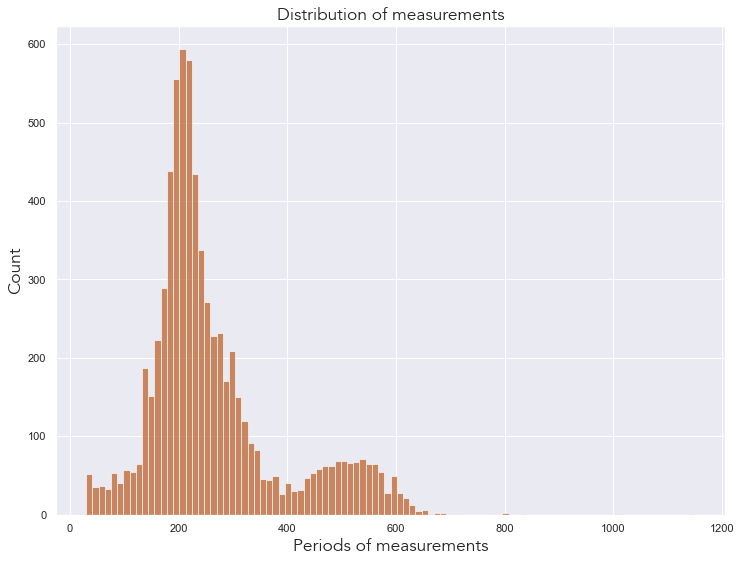

In [9]:
plt.figure(figsize=(12,9))
sns.histplot(data=pL,color='#BD632F') # drawing a histogram of the distribution of measurements
plt.title('Distribution of measurements', fontproperties=font)
plt.xlabel('Periods of measurements', fontproperties=font)
plt.ylabel('Count', fontproperties=font)
plt.show()

The graph above shows that most of our light curves have around 200 to 300 measurements, with a subsequent peak at about 500 measurements per light curve.

In [11]:
# TIME DIFFERENCE
tmL = []
for i in dataL.ids:
    lightc = dataL.get_light_curve(i)
    t, m, me = lightc.T
    time = t[len(t)-1] - t[0] # last time - first time
    tmL.append(time)

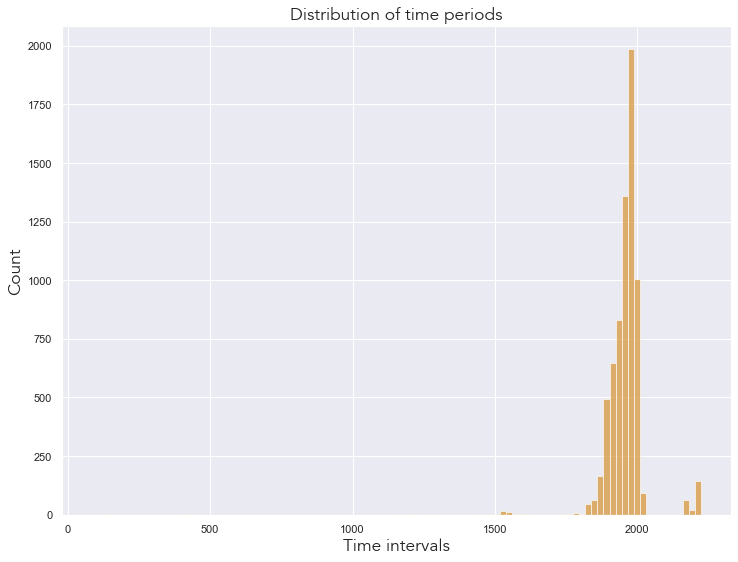

In [10]:
plt.figure(figsize=(12,9))
sns.histplot(data=tmL,color='#D8973C', bins=100)
plt.title('Distribution of time periods',fontproperties=font)
plt.xlabel('Time intervals',fontproperties=font)
plt.ylabel('Count', fontproperties=font)
plt.show()

This graph shows that most of our time intervals span around 1800 to 2000 days. So, no matter the variable star type, most actual time intervals are very long.

## `ZTF` dataset

The `Zwicky Transient Facility` is an optical time-domain survey that uses the Palomar 48-inch Schmidt telescope to observe the entire Northern hemisphere sky in 3 different bands: `g,` `r`, and `i`, and has been operating since October 2017. This telescope has a large field of view, taking in a lot of data.

All the data gathered by `ZTF` is stored at the IPAC, which can be accessed via IRSA, as shown in this project. All of the raw data was processed so that every pixel had an average of 5 bits, and although this increased sky noise by 1%, the increase is negligible. All the images were FITS images which the program processed in the following way:

1. **Preprocessing:** removing bias frames and flat field correction frames.

2. **Astrometry:** Using the `SCAMP` package, all objects were astrometrically calibrated to match the `GAIA` survey.

3. **Photometry:** All images were photometrically calibrated following the `PanSTARRS 1` survey.

4. **Final processing:** Finally, masks were made for saturation, bad pixels were removed, ghosts and any instrumental artifacts, and other defects.


Every image was then categorized as either a moving or a changing source using the `ZOGY` algorithm. Furthermore, point-like moving objects were identified using the custom `ZTF Moving-object Discovery Engine (ZMODE).` 

`ZTF` was able to observe the following objects:

**1. Transient objects**

These objects are supernovae found in other galaxies, and the `ZTF` survey captured their light curves.

**2. Neutrinos and gravitational-wave events**

The `ZTF` survey showed that scientists could use `ZTF` in the future to undertake observations of neutrinos and gravitational-wave events. 

**3. Variable objects**

These include variable stars but also light curves of asteroids. The light curves in the `ZTF`dataset were built upon every few months, and the light curves were stored in `HDF5` match files per each field of observation. `ZTF` contains many light curves, and some most notable types are *Be stars*, *RR Lyrae* stars, light curves of *NEOs*, *Asteroids*, and the activity of *Comets and Centaurs*.  

### Accessing the `ZTF` data

The `ZTF` data is on an extrenal API provided by the `IRSA` webpage. Since querying for the data takes a lot of time, we use **asynchronous** programming to tackle multiple queries at a time, significantly shortening the runtime. All light curves are searched by equatorial coordinates (found in `dataL.targets`) and saved as `DataFrames` inside an array, along with the search ID as a `tuple`. So, *array([(ID1, DataFrame object 1), (ID2, DataFrame object 2),...])*. All of the code can be found in the custom `ZTF_data.py` library.

In [12]:
#| code-fold: false
ZTF_data = data_ztf('ZTF_light_curves.npy')

Accessing the data!


In [13]:
print('Shape of the dataset:', ZTF_data[0][1].shape)
ZTF_data[0][1].head()

(2197, 4)


,mjd,mag,magerr,filtercode
0,58202.353634,16.516510,0.016864,zg
1,58202.357454,16.517498,0.016866,zg
2,58205.341262,16.568840,0.017013,zg
3,58205.392616,17.055435,0.019523,zg
4,58208.322326,16.585726,0.017066,zg


The ZTF data is structured so every light curve has an ID or the order it was processed in as the first element of a `tuple`, and the second element is a `Pandas DataFrame`, which contains the light curve data. It has 4 columns: `mjd` or the time values, `mag` or the magnitude values, `magerr` or the magnitude errors, and finally `filtercode` or the filter in which the data was taken in.

Every light curve was made in 3 filters: `zg`, `zr` and `zi`, or the green, red and infrared filters. Each filter has a different amount of observation points and gives us insight into the light curve's structure.

In [14]:
no = 0
na_id = []
for i in range(NUM_STARS):
    if ZTF_data[i][1].empty == True: # if the dataframe is empty,
        no += 1 # count it
        na_id.append(i)
print('Number of empty light curve DataFrames', no)

178
[21, 43, 48, 64, 75, 119, 138, 151, 165, 180]


We can see that 178 light curves in the ZTF datasets contain no values, meaning they were not found in the ZTF database. 

In [15]:
# NUMBER OF OBSERVATIONS
# ------------------------
pztf = []
for i in num:
    pztf.append(ZTF_data[i][1].shape[0])

total_obser_ztf = sum(pztf) # summing the number of observation for every light curve

9187878


The ZTF data contains 9 187 878 observations! That is almost nine times more than for the LINEAR data.

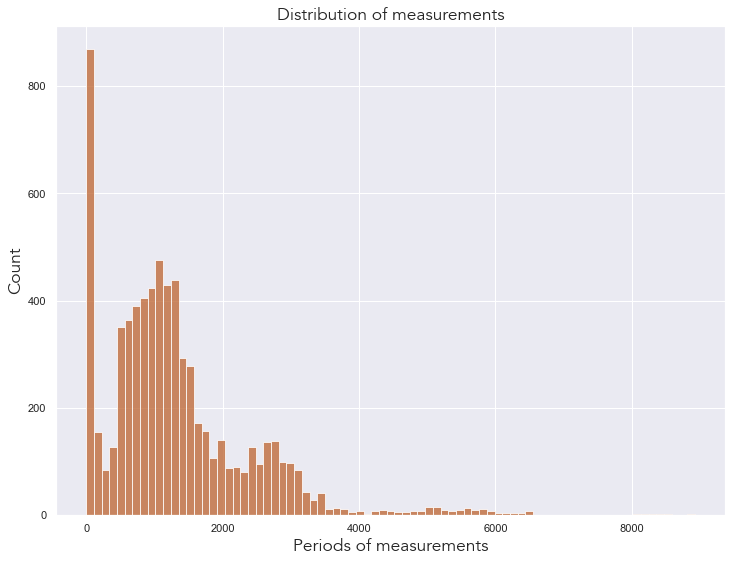

In [16]:
plt.figure(figsize=(12,9))
sns.histplot(data=pztf,color='#BD632F') # drawing a histogram of the distribution of measurements
plt.title('Distribution of measurements', fontproperties=font)
plt.xlabel('Periods of measurements', fontproperties=font)
plt.ylabel('Count', fontproperties=font)
plt.show()

The graph above shows that a considerable amount of light curves contain very few points in their observation, with another peak at around 1000 observations. 

### Splitting the data into respective filters for analysis

In [17]:
#| code-fold: false
ZTF_g = []
ZTF_r = []
ZTF_i = []

for i in tqdm(range(NUM_STARS)):
    lc = ZTF_data[i][1]
    # green
    lcg = lc.loc[lc['filtercode']=='zg']
    lcg = lcg.reset_index()
    lcg = lcg.drop(['index'],axis=1)
    ZTF_g.append((i, lcg))
    # red
    lcr = lc.loc[lc['filtercode']=='zr']
    lcr = lcr.reset_index()
    lcr = lcr.drop(['index'],axis=1)
    ZTF_r.append((i, lcr))
    # infrared
    lci = lc.loc[lc['filtercode']=='zi']
    lci = lci.reset_index()
    lci = lci.drop(['index'],axis=1)
    ZTF_i.append((i, lci))

100%|██████████| 7010/7010 [00:26<00:00, 267.98it/s]


Now we have separated every star by its filter! We now have 3 respective datasets of the same stars where each dataframe encompases the filters of every light curve.

### Introductory statistics on `ZTF` data

In [24]:
# TIME DIFFERENCE
# ----------------

time_g = []
time_r = []
time_i = []

for i in tqdm(range(NUM_STARS)):
    lcg = ZTF_g[i][1]
    lcr = ZTF_r[i][1]
    lci = ZTF_i[i][1]

    # green
    if lcg.shape[0] > 0:
        n = lcg.shape[0]-1
        timeg = lcg['mjd'][n] - lcg['mjd'][0]
        time_g.append(timeg)
    else:
        pass

    # red
    if lcr.shape[0] > 0:
        n = lcr.shape[0]-1
        timer = lcr['mjd'][n] - lcr['mjd'][0]
        time_r.append(timer)
    else:
        pass

    # infrared
    if lci.shape[0] > 0:
        n = lci.shape[0]-1
        timei = lci['mjd'][n] - lci['mjd'][0]
        time_i.append(timei)
    else:
        pass

100%|██████████| 7010/7010 [00:01<00:00, 3695.43it/s]


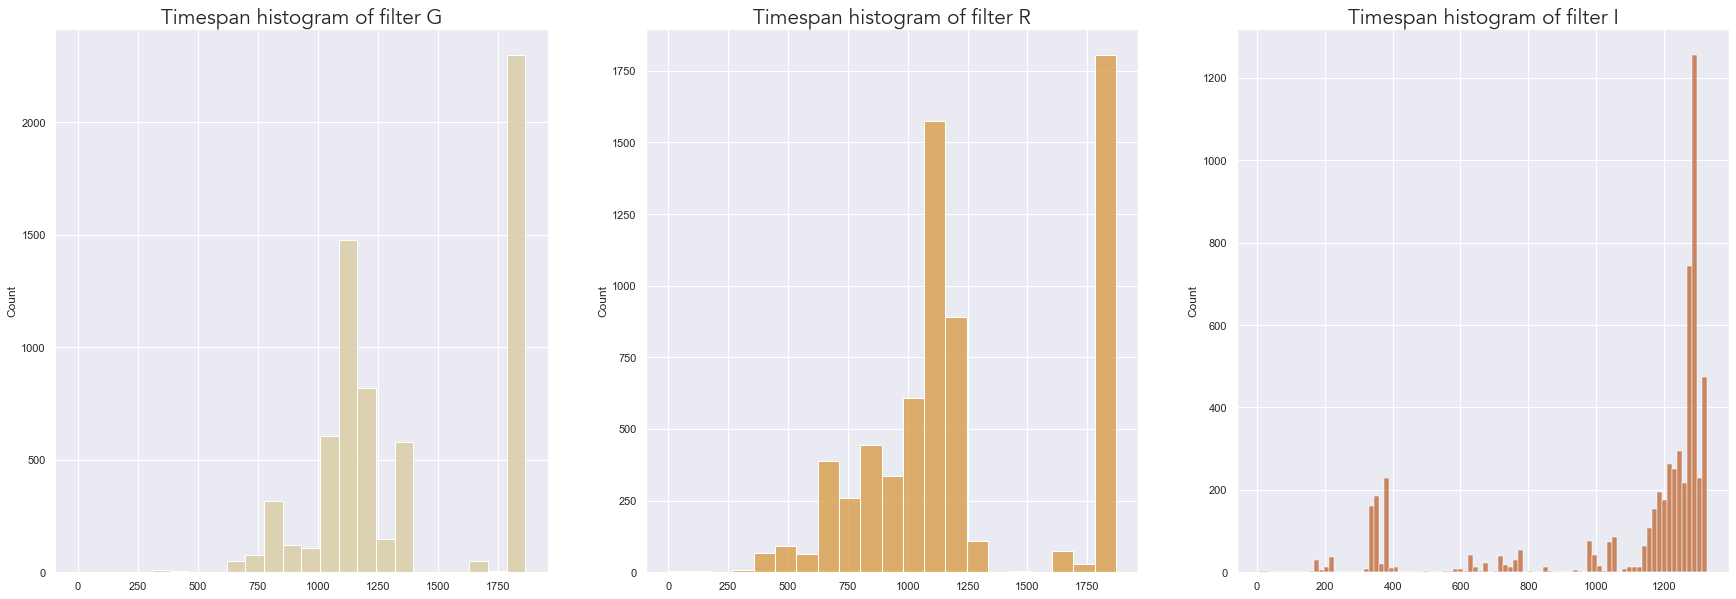

In [25]:
# PLOTTING TIME DIFFERENCE
# -------------------------

fig, axs = plt.subplots(1,3, figsize=(30,10))
# histogram 1
axs[0].set_title('Timespan histogram of filter G',fontproperties=font)
sns.histplot(data=time_g,color='#D8C99B',ax=axs[0]) # drawing a histogram of the distribution of measurements
#histogram 2
axs[1].set_title('Timespan histogram of filter R',fontproperties=font)
sns.histplot(data=time_r,color='#D8973C',ax=axs[1]) # drawing a histogram of the distribution of measurements
#histogram 3
axs[2].set_title('Timespan histogram of filter I',fontproperties=font)
sns.histplot(data=time_i,color='#BD632F',ax=axs[2]) # drawing a histogram of the distribution of measurements

plt.show()

In the `g` filter, most timespans are of 1750 days, with a subsequent peak at around 1100 days. In the `r` filter we can see a similar distribution, although the peak at aroun 1100 is much stronger. Finally, in the `i` filter, most timespans are around 1300 days, with a subsequent peak at around 400! This is the shortest inerval thus far.

# Analysis of `LINEAR` and `ZTF` data

## Descriptive statistics of magnitude values

##### `LINEAR` dataset

In [26]:
#| code-fold: false
stats_L = lc_descriptive_stats_table_LINEAR('mag')

Argument received: mag


In [27]:
stats_L.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
10003298,15.920224,15.8880,0.159858,15.679,16.360,0.659768,-0.482567,0.681
10004892,16.839543,16.8440,0.236847,16.382,17.975,0.767109,3.528837,1.593
10013411,15.574235,15.5020,0.192148,15.400,16.391,2.227095,4.286783,0.991
10021274,14.939383,14.9885,0.231373,14.289,15.330,-0.624265,-0.566168,1.041
10022663,14.253744,14.2935,0.227889,13.698,14.665,-0.550420,-0.498097,0.967


#### `ZTF` dataset

In [28]:
#| code-fold: false
stats_Z_g = lc_descriptive_stats_table_ZTF('mag', ZTF_g)

In [29]:
stats_Z_g.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
mag,16.735973,16.682770,0.190980,16.355003,17.274315,0.547621,-0.987585,0.919311
mag,17.090297,17.166143,0.248268,16.568600,17.351080,-1.005061,-0.432566,0.782480
mag,16.204822,16.146278,0.152526,15.931999,16.806747,2.009203,3.217131,0.874748
mag,15.013304,15.165165,0.365250,14.104170,15.602118,-0.741975,-0.814440,1.497949
mag,14.372281,14.500145,0.362280,13.489013,15.489503,-0.676807,-0.701880,2.000490


In [30]:
#| code-fold: false
stats_Z_r = lc_descriptive_stats_table_ZTF('mag', ZTF_r)

In [31]:
stats_Z_r.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
mag,15.897570,15.851342,0.167484,15.633669,16.323614,0.522559,-1.009893,0.689945
mag,16.785922,16.774748,0.220514,16.429140,17.081219,-0.150690,-1.395480,0.652079
mag,15.458849,15.393452,0.165171,15.277586,16.366425,2.121737,3.979763,1.088839
mag,14.851248,14.929792,0.255162,13.541904,15.399588,-0.686116,-0.339955,1.857683
mag,14.196490,14.250234,0.245730,13.636862,14.918344,-0.551952,-0.699978,1.281482


In [32]:
#| code-fold: false
stats_Z_i = lc_descriptive_stats_table_ZTF('mag', ZTF_i)

In [33]:
stats_Z_i.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
mag,15.600686,15.549002,0.168734,15.294890,15.917844,0.405756,-1.221085,0.622954
mag,15.128821,15.077989,0.133336,15.009691,15.657438,2.311716,4.382408,0.647747
mag,14.868257,14.941725,0.199451,14.308695,15.290393,-0.604343,-0.736272,0.981698
mag,15.700998,15.610683,0.229866,15.428493,16.695438,1.166536,0.739817,1.266946
mag,15.767120,15.766270,0.028933,15.552393,15.897695,-1.391850,16.485549,0.345302


##### Plotting the results

We need to reset all the indexes so that the results can be plotted!

In [39]:
stats_Z_g = stats_Z_g.reset_index(drop=True)
stats_Z_r = stats_Z_r.reset_index(drop=True)
stats_Z_i = stats_Z_i.reset_index(drop=True)

True
True
True
True


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


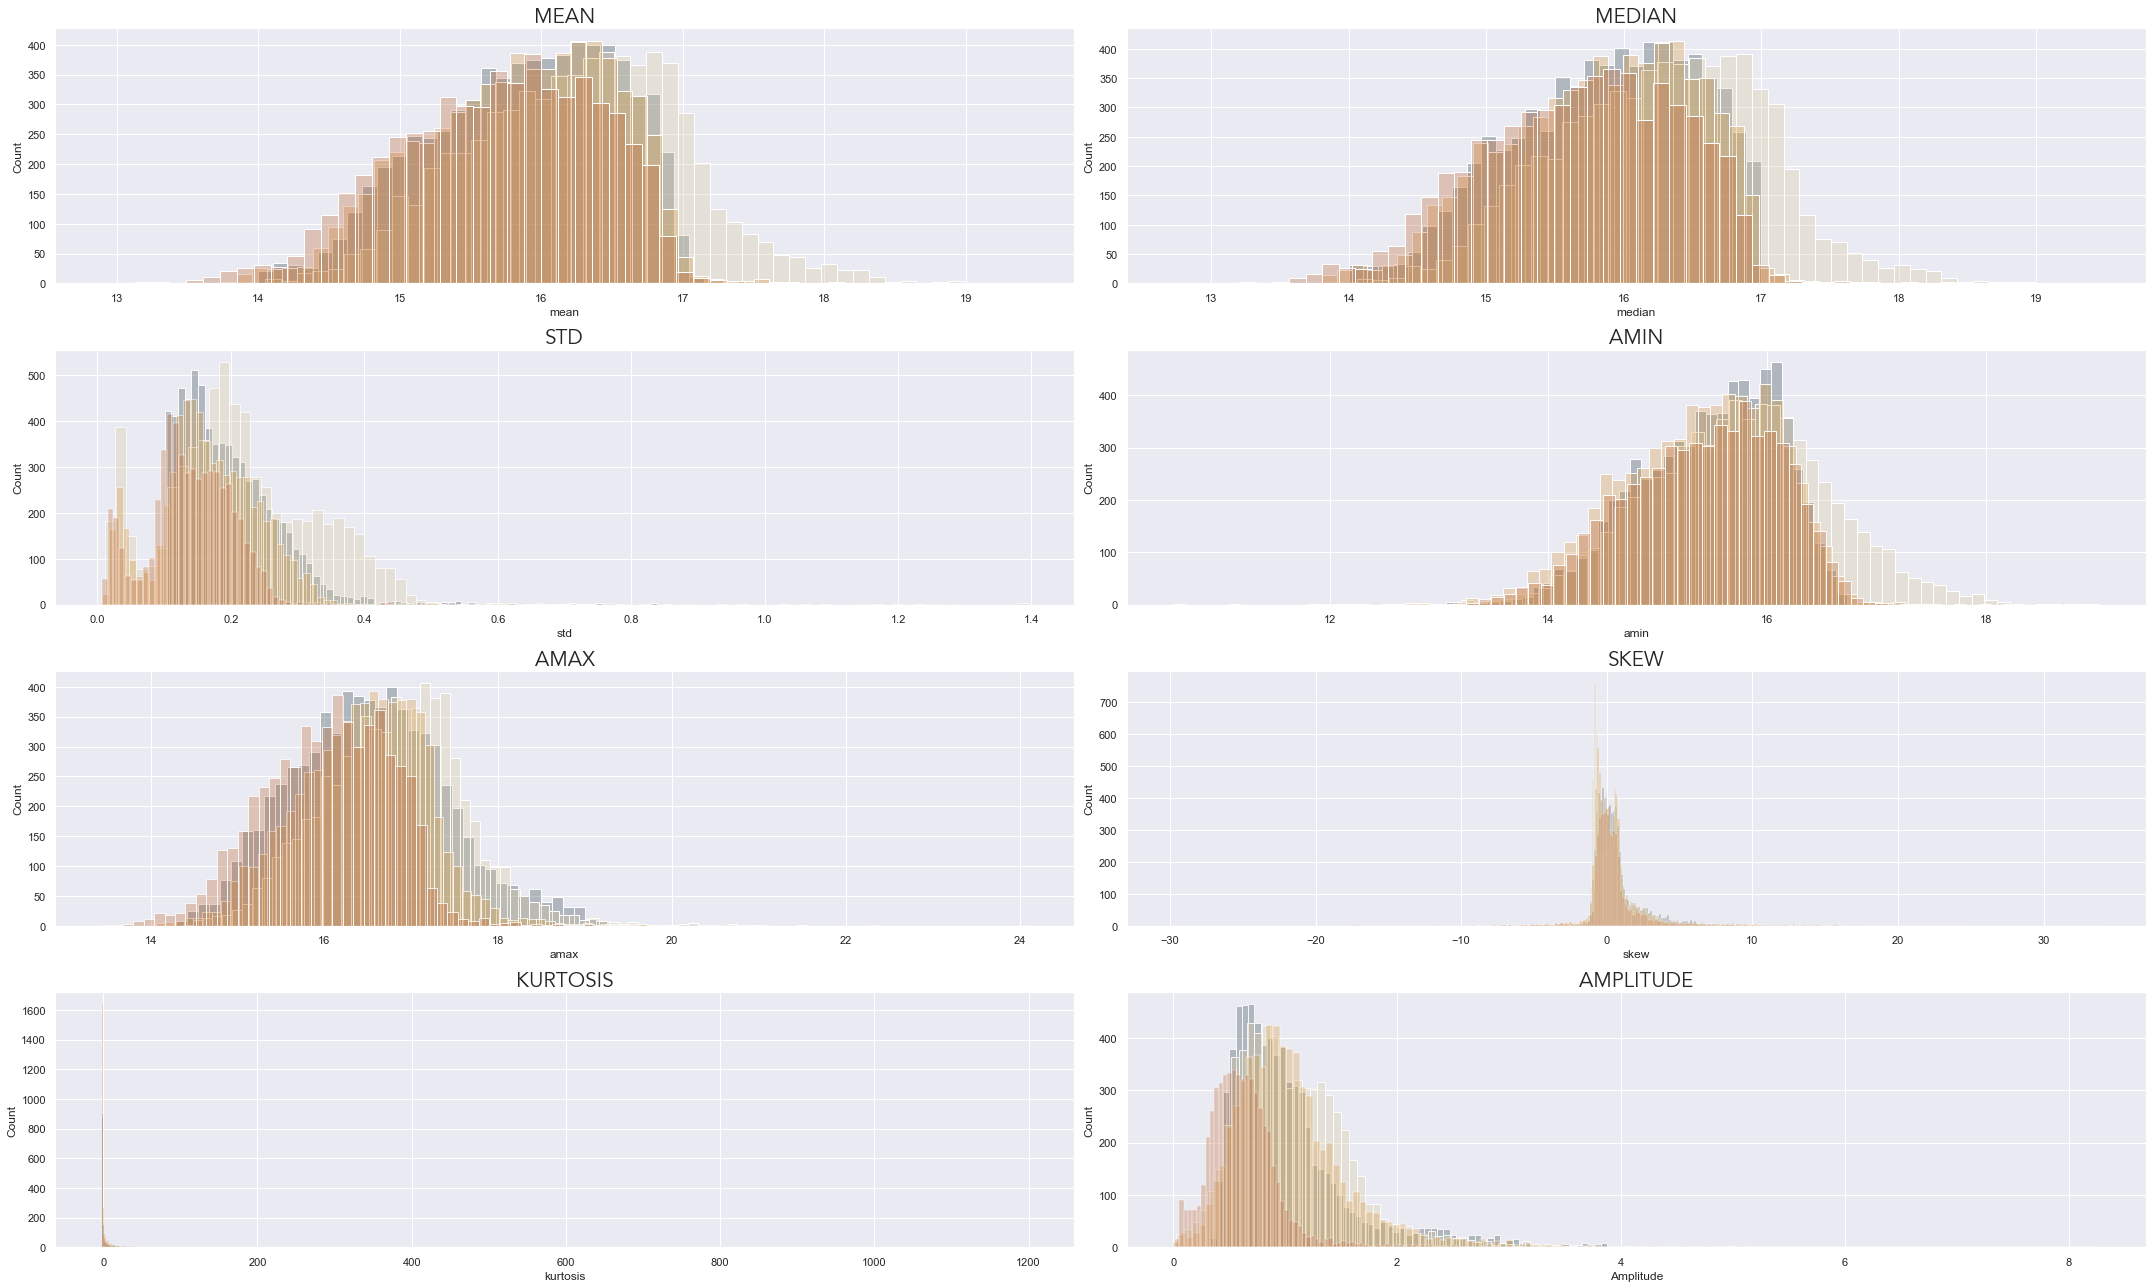

In [44]:
columns = ['mean', 'median', 'std', 'amin', 'amax', 'skew','kurtosis','Amplitude']

fig, ax = plt.subplots(4,2, figsize=(30,18)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in tqdm(range(len(columns))): #plot the same type of graph for every property
    ax[i].set_title(columns[i].upper(), fontproperties=font) # the title of the graph is the column name
    sns.histplot(data=stats_L,x=columns[i],ax=ax[i], color='#273E47', alpha=0.3) # blue
    sns.histplot(data=stats_Z_g, x=columns[i], ax=ax[i], color='#D8C99B',alpha=0.3) # light color
    sns.histplot(data=stats_Z_r, x=columns[i], ax=ax[i], color='#D8973C',alpha=0.3) # orange color
    sns.histplot(data=stats_Z_i, x=columns[i], ax=ax[i], color='#BD632F',alpha=0.3) # dark orange color
fig.tight_layout()
plt.show()

From the graphs above we can make a few conclusions.

1. **The mean graph**: the distribution from all the data is more or less the same, and the most common mean is from 16 to 17 magnitudes. The most visible difference is how the green filter of the `ZTF` data has a longer tail towards lower magnitudes, while the infrared filter has a longer tail towards the higher magnitudes. 

2. **The median graphs**: the distribution from all the data is kind of the same, where the most common median is around 16 magnitudes. The observation from the mean graph also applies here.

3. **The standard deviation graph**: Here we can see large discrepancies. There are 2 peaks: one peak is at around 0 (meaning the data is very concentrated), and another peak is at around 0.2 (which is also very concentrated around the mean). The `ZTF` green filter has a distribution where many values are inbetween 0.2 and 0.4. The `LINEAR` dataset doesn't have a peak at around 0.

4. **The minimum graph**: Here the distributions are almost identical, and most minimums range at around 16 magnitudes. The `ZTF` green filter has a distribution ranging all the way to 18 magnitudes.
5. **The maximum graph**: Again, the distribution is almost identical, where values range from 14 magnitudes to 20 magnitudes.

6. **The skew graph**: All the distributions are almost identical, and most values range around 0, meaning that the distributions aren't very skewed.

7. **The kurtosis graph**: again, the distributions are almost identical, and almost every value is around 0, meaning that most of our light curves follow a normal distribution.

8. **The amplitude graph**: Here the distributions aren't so similar. The most common `LINEAR` amplitude is a bit less than 1 magnitude, for `ZTF` green data is around 1.5, for `ZTF` red is around 1-1.1 magnitudes, and finally for `ZTF` infrared the most common amplitude is around 0.6-0.7 magnitudes. The total range is from close to 0 all the way to 4 magnitudes!


## Descriptive statistics of magnitude error values

#### `LINEAR` data

In [46]:
#| code-fold: false
stats_L_er = lc_descriptive_stats_table_LINEAR('magerr')
stats_L_er.head()

Argument received: magerr


,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
10003298,0.048587,0.044,0.018496,0.018,0.115,1.239252,1.627132,0.097
10004892,0.109491,0.098,0.053818,0.039,0.332,1.606721,3.142803,0.293
10013411,0.039447,0.028,0.042827,0.015,0.448,6.871714,56.888840,0.433
10021274,0.020528,0.020,0.009136,0.009,0.056,1.671405,3.435779,0.047
10022663,0.012114,0.011,0.005738,0.006,0.043,2.365310,8.099770,0.037


#### `ZTF` data

In [47]:
#| code-fold: false
stats_Z_g_er = lc_descriptive_stats_table_ZTF('magerr', ZTF_g)
stats_Z_g_er.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
magerr,0.016739,0.016988,0.001702,0.013247,0.021473,-0.194755,-0.749422,0.008226
magerr,0.019975,0.020332,0.001545,0.016999,0.021836,-0.792410,-0.726045,0.004837
magerr,0.014782,0.014636,0.000557,0.013328,0.017227,1.396176,4.349406,0.003898
magerr,0.013280,0.013297,0.000231,0.011187,0.013583,-7.032957,54.219491,0.002396
magerr,0.014277,0.014225,0.000269,0.012926,0.014828,-2.337813,10.403696,0.001902


In [48]:
#| code-fold: false
stats_Z_r_er = lc_descriptive_stats_table_ZTF('magerr', ZTF_r)
stats_Z_r_er.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
magerr,0.014733,0.014637,0.000322,0.013360,0.015830,-0.113479,3.489046,0.002469
magerr,0.016733,0.016517,0.001295,0.014859,0.018631,0.055509,-1.437554,0.003772
magerr,0.013516,0.013459,0.000139,0.013451,0.014983,3.855843,23.218715,0.001532
magerr,0.014877,0.014798,0.000269,0.013531,0.015498,-0.974238,5.084106,0.001966
magerr,0.014054,0.014062,0.000090,0.013198,0.014289,-5.911293,38.424977,0.001091


In [49]:
#| code-fold: false
stats_Z_i_er = lc_descriptive_stats_table_ZTF('magerr', ZTF_i)
stats_Z_i_er.head()

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
magerr,0.013091,0.013459,0.000607,0.011990,0.013925,-0.514070,-1.374902,0.001935
magerr,0.012506,0.012472,0.000093,0.012461,0.012987,3.139535,9.975130,0.000526
magerr,0.014519,0.014490,0.000056,0.014481,0.014778,1.662839,2.298835,0.000298
magerr,0.013121,0.012924,0.000448,0.012756,0.016380,2.606883,11.937356,0.003624
magerr,0.015054,0.015051,0.000048,0.014756,0.015298,-0.152441,9.746567,0.000542


#### Plotting the results

In [50]:
stats_Z_g_er = stats_Z_g_er.reset_index(drop=True)
stats_Z_r_er = stats_Z_r_er.reset_index(drop=True)
stats_Z_i_er = stats_Z_i_er.reset_index(drop=True)

True
False
False
False


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


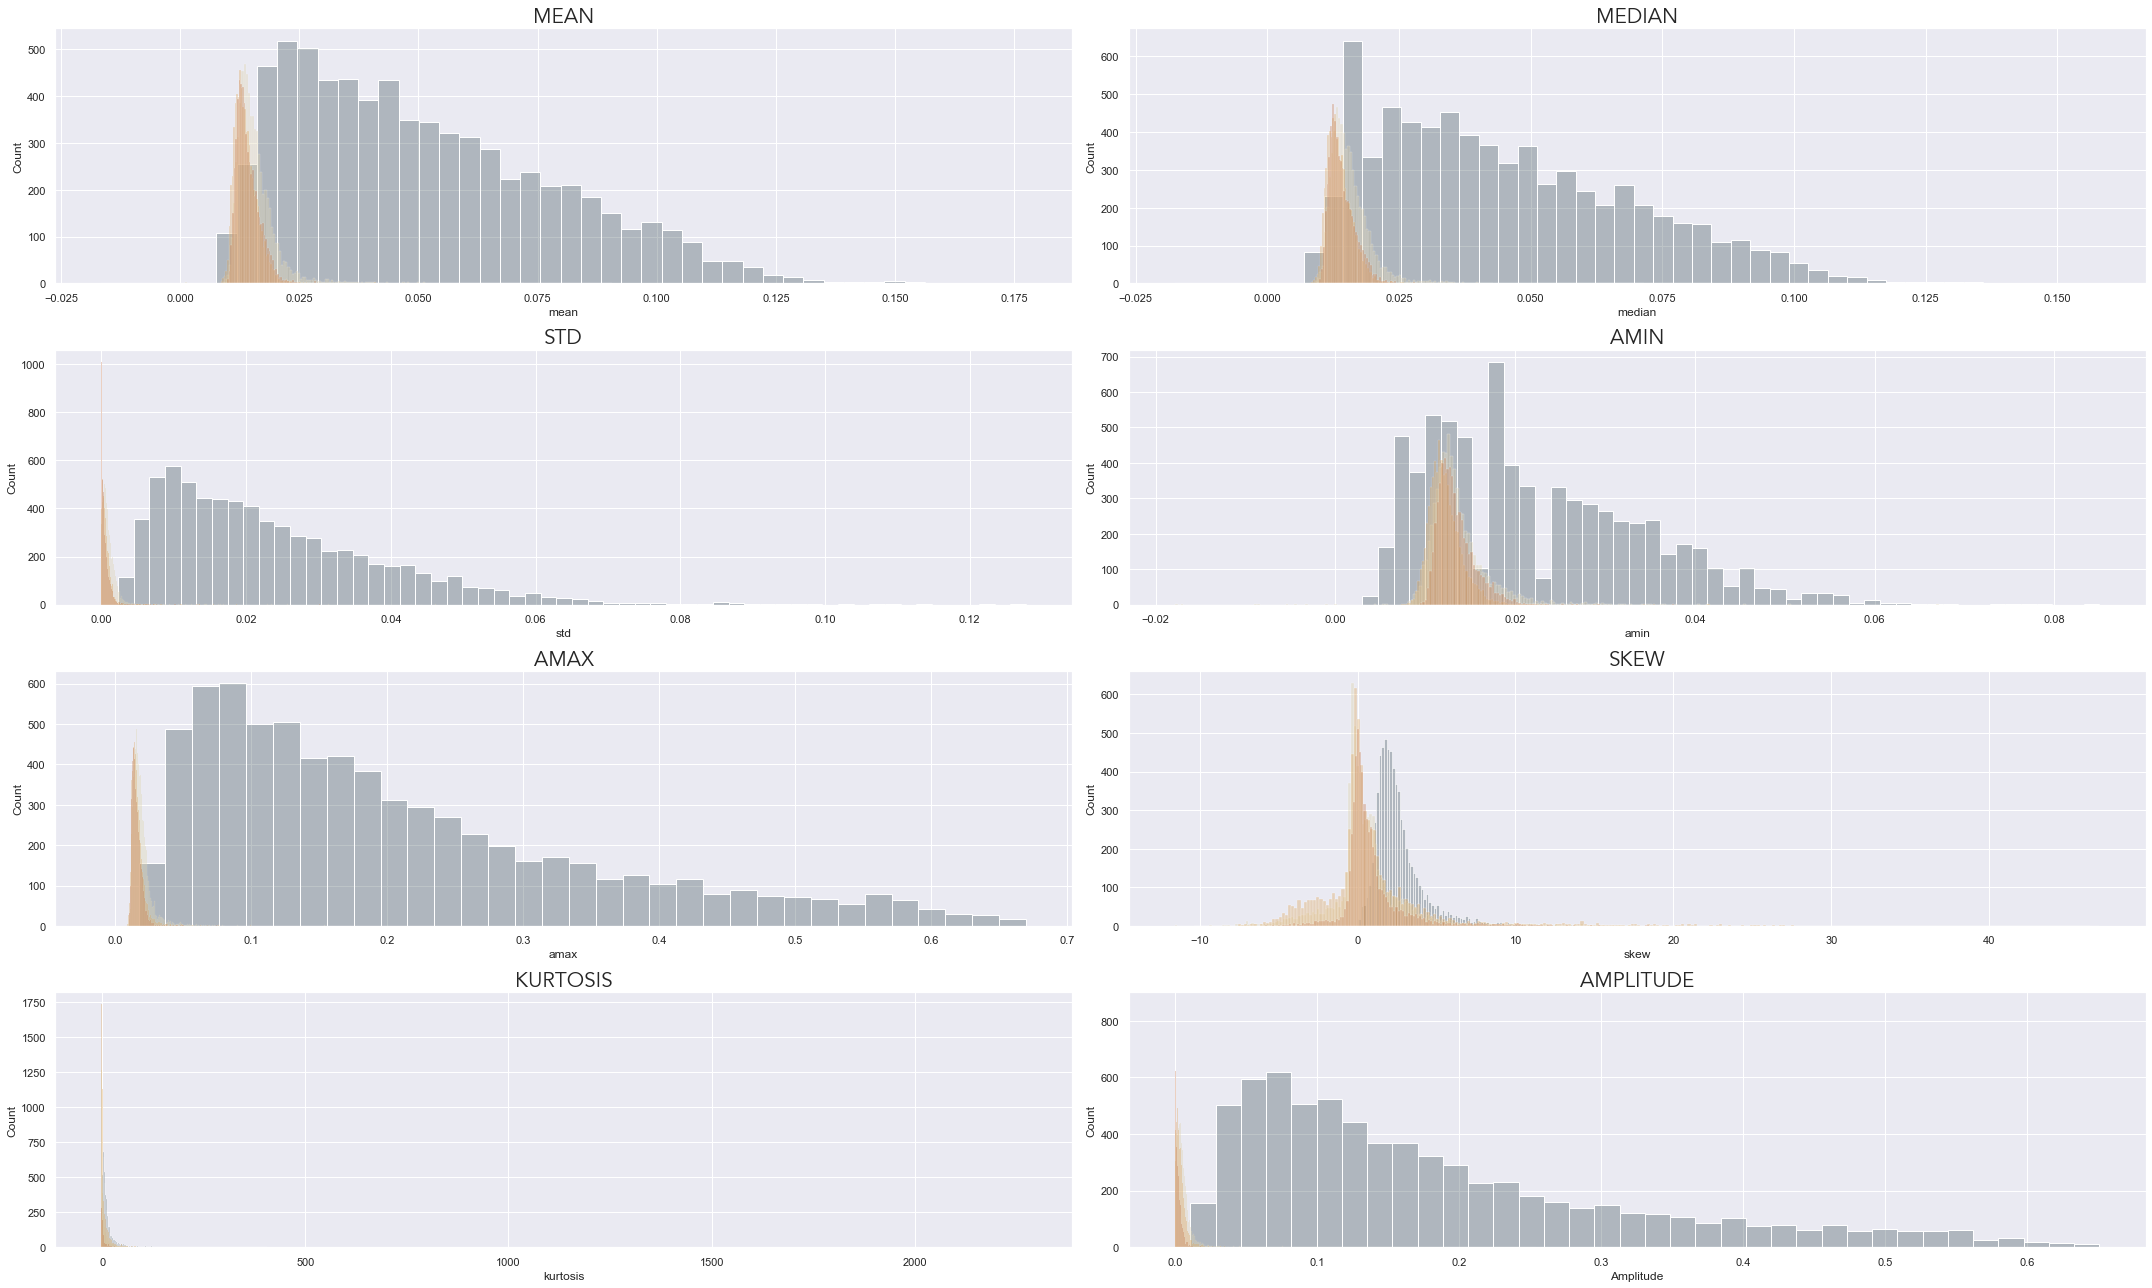

In [51]:
columns = ['mean', 'median', 'std', 'amin', 'amax', 'skew','kurtosis','Amplitude']

fig, ax = plt.subplots(4,2, figsize=(30,18)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in tqdm(range(len(columns))): #plot the same type of graph for every property
    ax[i].set_title(columns[i].upper(), fontproperties=font) # the title of the graph is the column name
    sns.histplot(data=stats_L_er,x=columns[i],ax=ax[i], color='#273E47', alpha=0.3) # blue
    sns.histplot(data=stats_Z_g_er, x=columns[i], ax=ax[i], color='#D8C99B',alpha=0.3) # light color
    sns.histplot(data=stats_Z_r_er, x=columns[i], ax=ax[i], color='#D8973C',alpha=0.3) # orange color
    sns.histplot(data=stats_Z_i_er, x=columns[i], ax=ax[i], color='#BD632F',alpha=0.3) # dark orange color
fig.tight_layout()
plt.show()

From the graphs above, we can clearly see that many attributes from `LINEAR` and `ZTF` data do not match. 
1. **The mean graph**: The most common mean error for `ZTF` in all filters is around 0.015, while for `LINEAR` it is around 0.025 with many light curves with much higher values.

2. **The median graph**: Again, a huge difference. The most common median error for `ZTF` in all filters is again around 0.015 while for `LINEAR` its again from 0.025 to higher values, all the way to 0.125.

3. **The standard deviation graph**: Most values for standard deviation in all `ZTF` filters is around 0 (very concentrated around the mean), while for `LINEAR` the values are a bit more spead out, taking on values from around 0.02 to 0.04. 

4. **The minimum graph**: Most values for the minimum error range around 0.01 for all `ZTF` filters, but for `LINEAR` the distribution doesn't have a clear peak, but the values range from 0.01 to 0.04.

5. **The maximum graph**: most values for the max are close to 0 for all `ZTF` filters, but for `LINEAR` the range is very large, from around 0 all the way o 0.6. 

6. **The skew graph**: most values for the skewness for all `ZTF` filters is around 0, but still fairly spread out in both directions. The `LINEAR` values are slightly above 0 and a bit spread out but not as much.

7. **The kurtosis graph**: the only graph where both distributions are almost identical and the value is almost 0.

8. **The amplitude graph**: most amplitudes for all `ZTF` filters are from 9 to around 0.01, while for `LINEAR` they range from 0.01 all the way to 0.6. 


From all of this we can conclude that `LINEAR` has much larger observational errors proportional to the `ZTF` errors.

# Plotting light curves

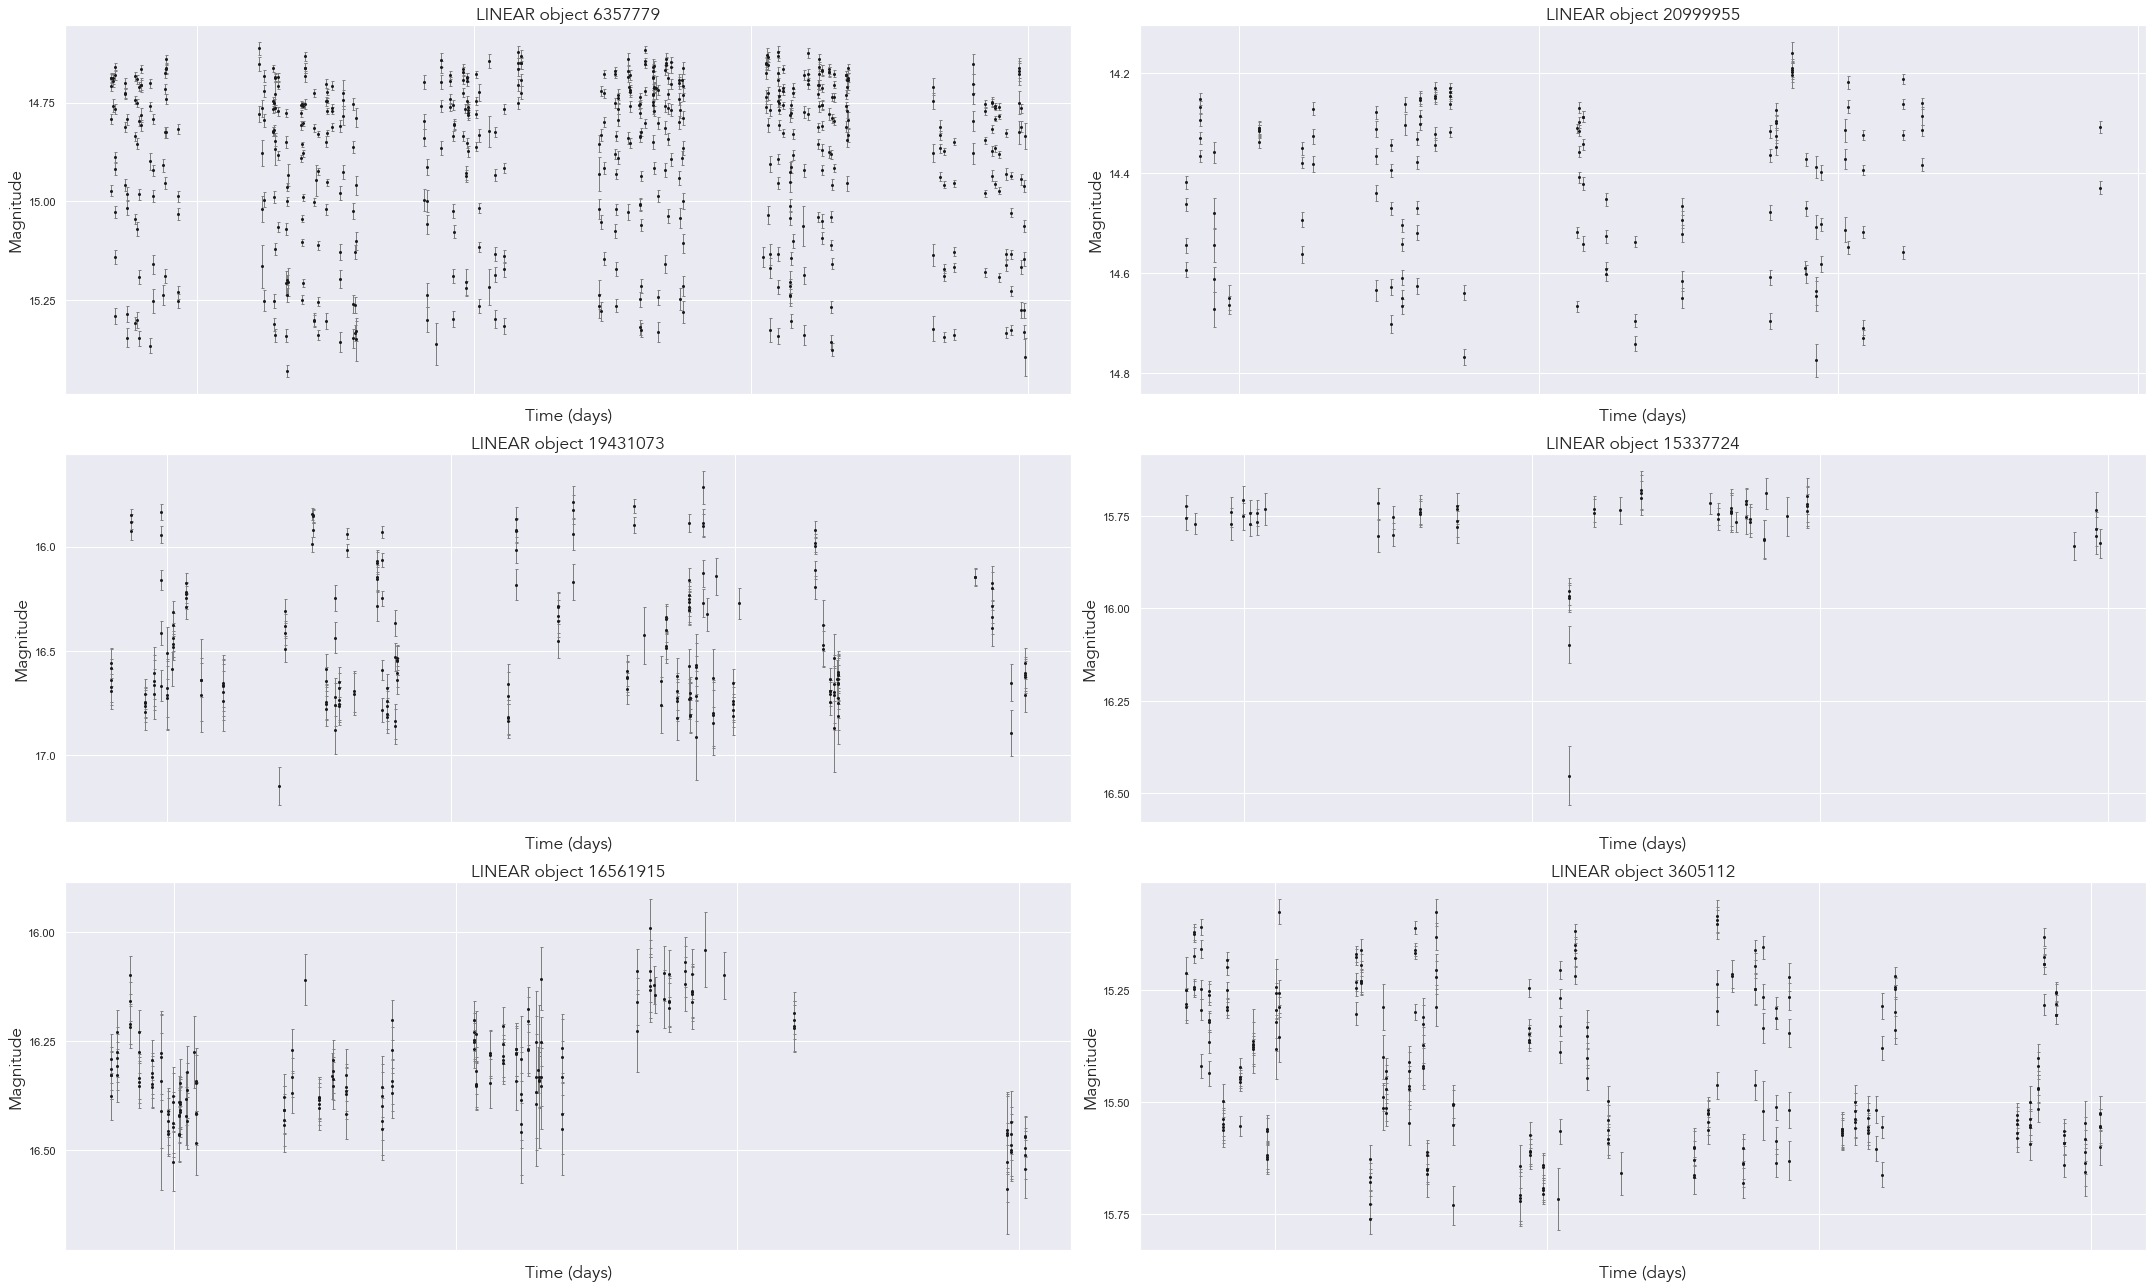

In [60]:
# LINEAR DATA
# -------------
lc_LINEAR()

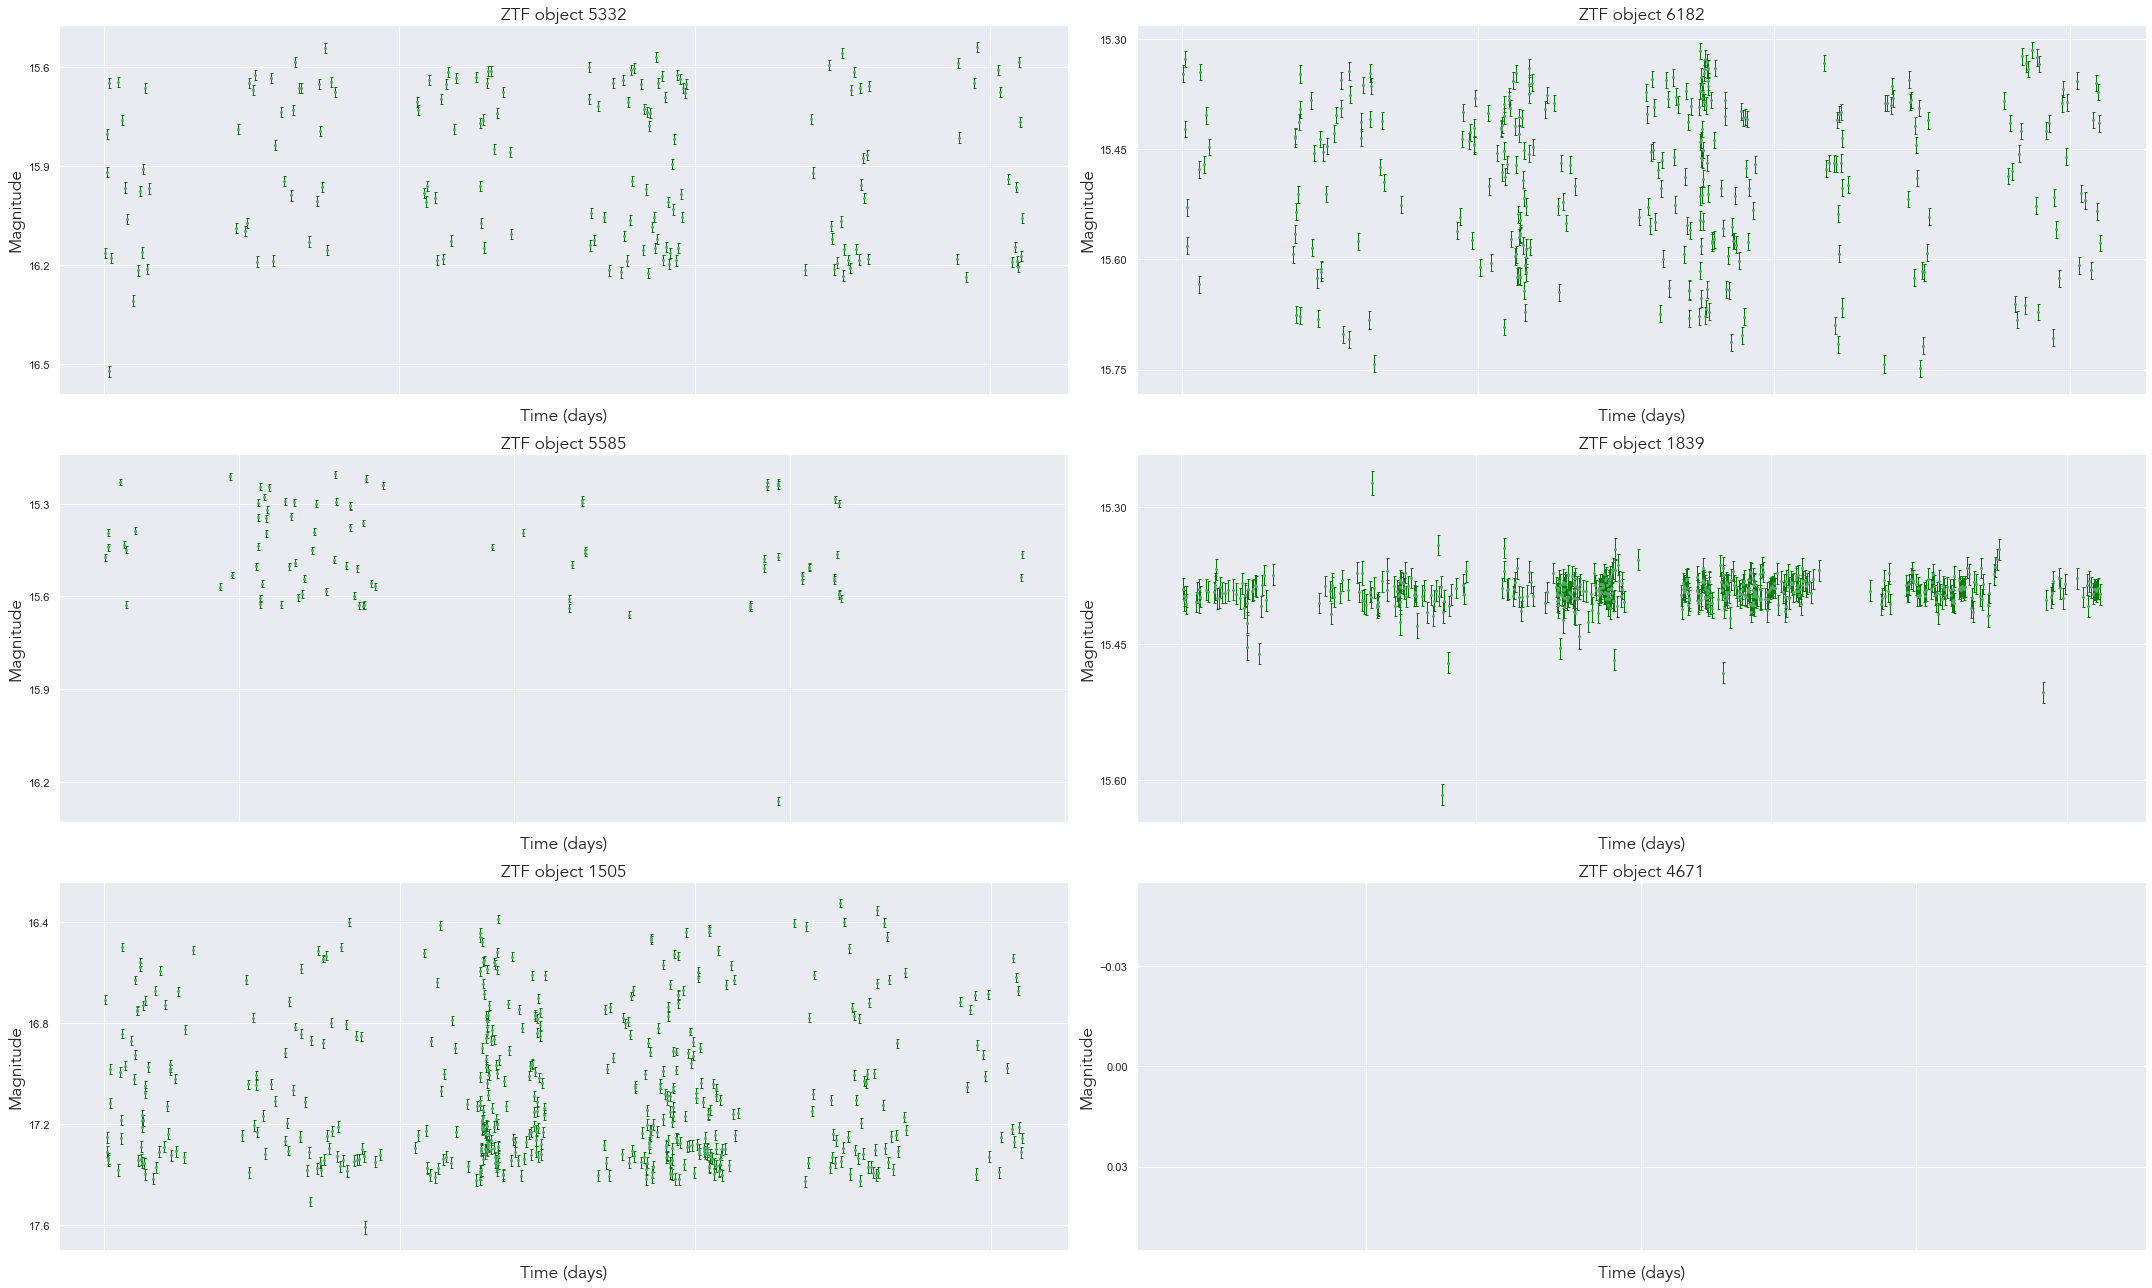

In [18]:
# GREEN FILTER
lc_ZTF(ZTF_g, '.g', 'green')

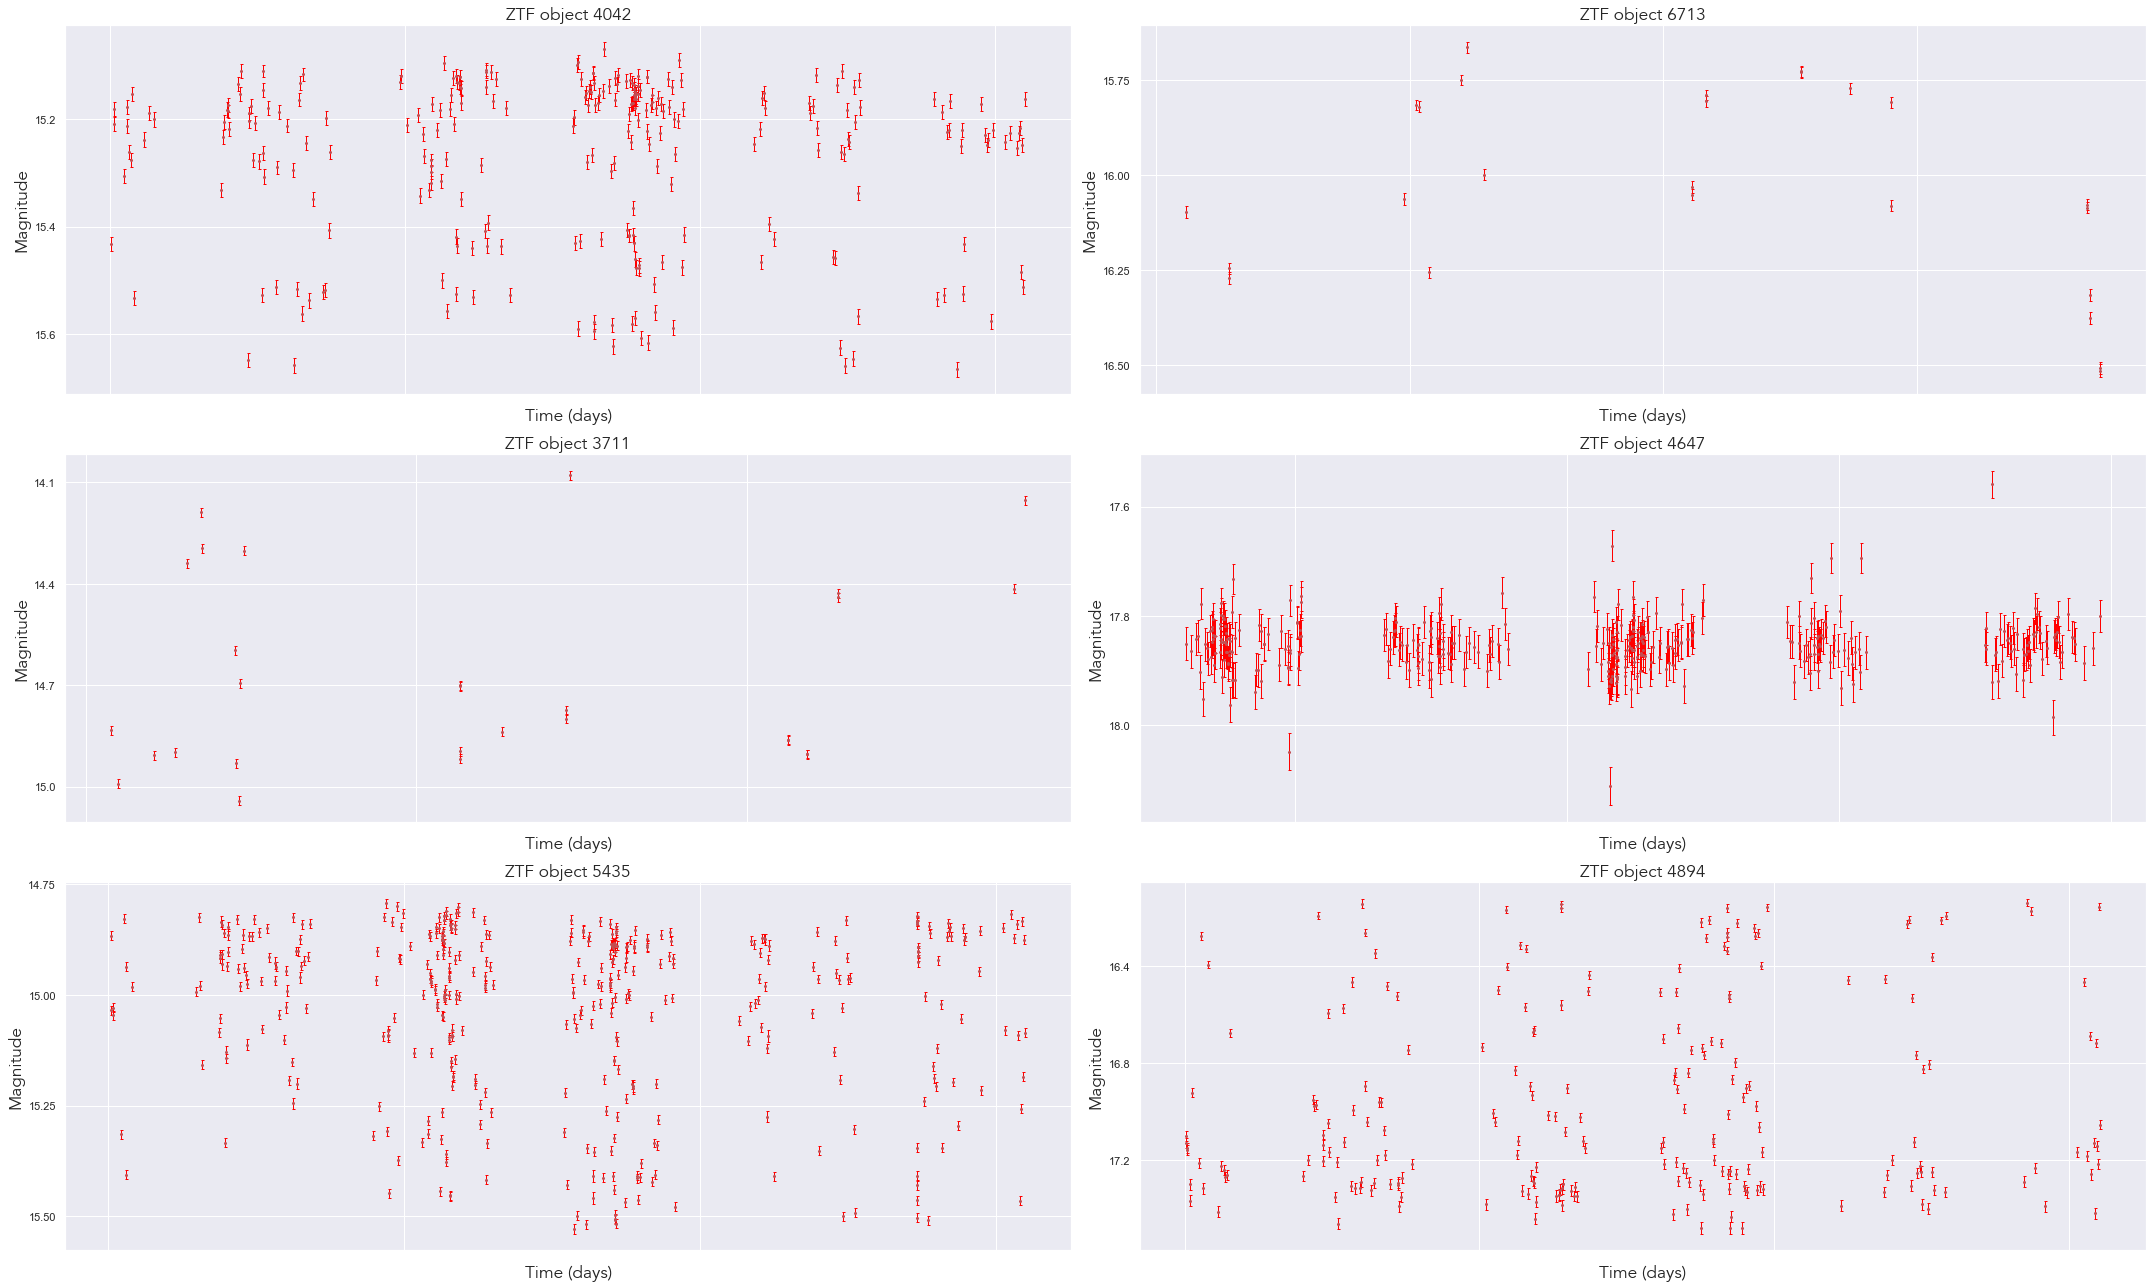

In [20]:
# RED FILTER
lc_ZTF(ZTF_g, '.r', 'red')

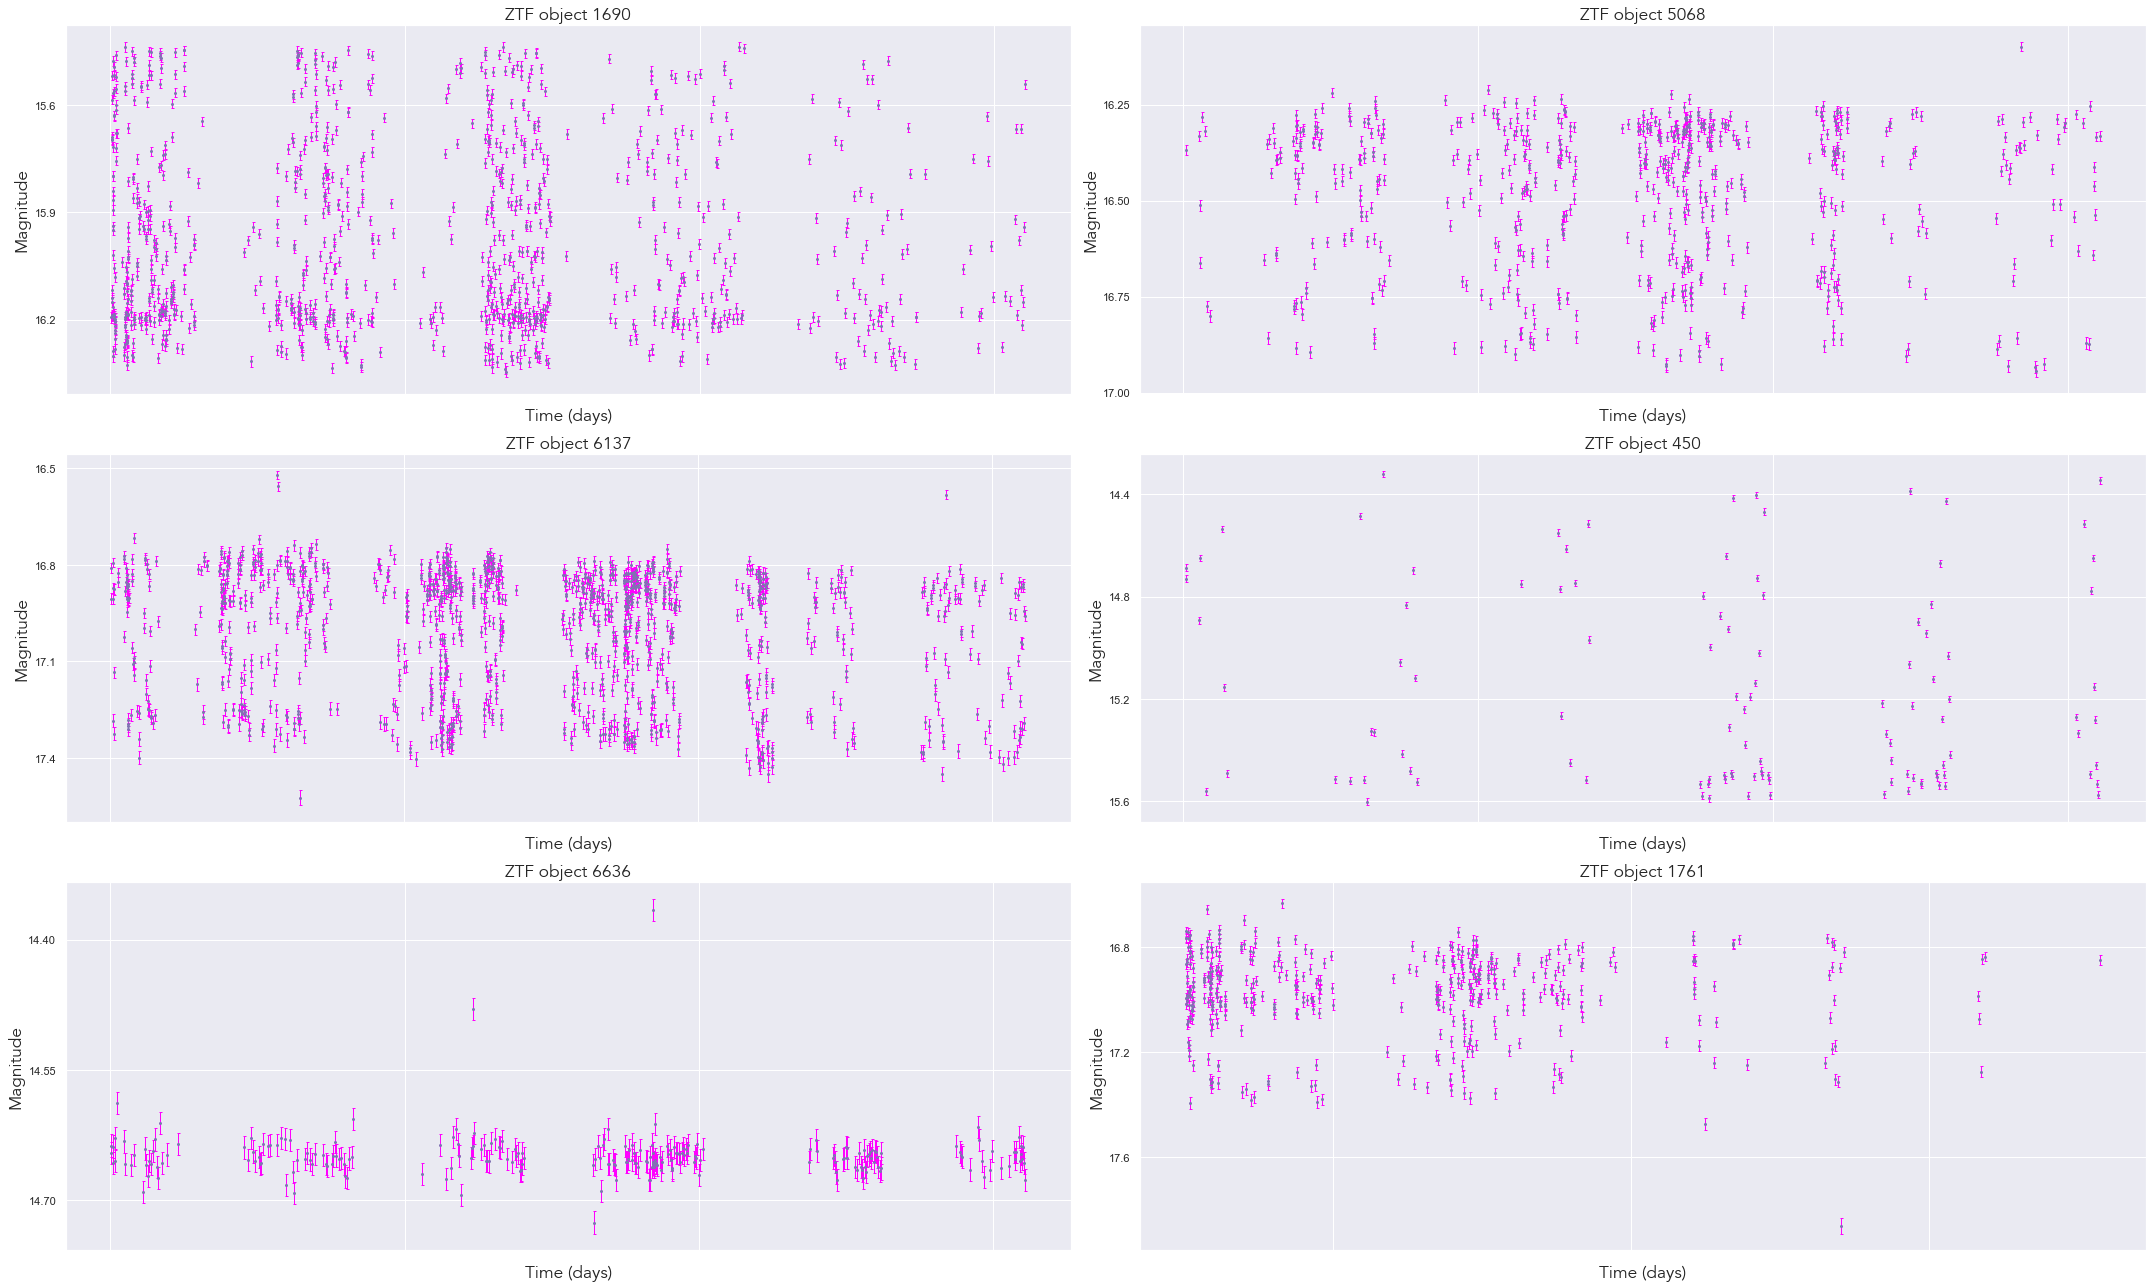

In [22]:
# INFRARED FILTER
lc_ZTF(ZTF_g, '.m', 'magenta')

---

Now that we have a basic understanding of both `LINEAR` and `ZTF` data, we can continue analyzing the light curves themselves. We will analyze light curves in the following notebook by calculating their periods, fits and analyzing their periodograms in search for the Blazhko effect.